In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install neurokit2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load data
pkl_file = '/content/drive/MyDrive/WESAD_pkl/S2.pkl'
subject_id = os.path.basename(pkl_file).split('.')[0]
with open(pkl_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Extract ECG and labels
ecg = data['signal']['chest']['ECG']  # shape (n_samples, 2)
labels = data['label']                # shape (n_samples,)


# to use the first colum from numpy array
ecg_signal = ecg[:, 0]

# Ensuring same length for DataFrame
min_len = min(len(ecg_signal), len(labels))
ecg_signal = ecg_signal[:min_len]
labels = labels[:min_len]

# Create DataFrame
df = pd.DataFrame({
    'ECG': ecg_signal,
    'Label': labels
})

# Duration in seconds
duration_seconds = len(ecg_signal) / 700
print(f"ECG Duration: {duration_seconds:.2f} seconds")

# Remove entries with labels 0, 5, 6, or 7
filtered_df = df[~df['Label'].isin([0, 5, 6, 7])].reset_index(drop=True)

# Check result
print(filtered_df['Label'].unique())

filtered_df.head()


ECG Duration: 6079.00 seconds
[1 2 4 3]


,ECG,Label
0,0.030945,1
1,0.033646,1
2,0.033005,1
3,0.031815,1
4,0.030350,1


In [ ]:

import neurokit2 as nk
import pandas as pd

# 30 seconds of ECG at 700Hz
sampling_rate = 700
ecg_segment = filtered_df['ECG'].values[:30 * sampling_rate]

# this processes ECG to detect peaks & clean the  signal
signals, info = nk.ecg_process(ecg_segment, sampling_rate=sampling_rate)

# Extracting HRV features
hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=sampling_rate, show=False)
print(hrv_features.T)





                        0
HRV_MeanNN     734.761905
HRV_SDNN       114.715514
HRV_SDANN1            NaN
HRV_SDNNI1            NaN
HRV_SDANN2            NaN
HRV_SDNNI2            NaN
HRV_SDANN5            NaN
HRV_SDNNI5            NaN
HRV_RMSSD       72.781547
HRV_SDSD        73.125991
HRV_CVNN         0.156126
HRV_CVSD         0.099055
HRV_MedianNN   704.285714
HRV_MadNN       84.720000
HRV_MCVNN        0.120292
HRV_IQRNN      126.428571
HRV_SDRMSSD      1.576162
HRV_Prc20NN    649.714286
HRV_Prc80NN    820.571429
HRV_pNN50       23.076923
HRV_pNN20       64.102564
HRV_MinNN      594.285714
HRV_MaxNN     1058.571429
HRV_HTI          7.800000
HRV_TINN        85.937500


In [ ]:
import neurokit2 as nk
import pandas as pd
import numpy as np
from tqdm import tqdm

# Constants
sampling_rate = 700
window_duration = 30  # seconds
window_size = sampling_rate * window_duration

# Store HRV feature rows
feature_rows = []

# Iterate over non-overlapping 30-second windows
for start in tqdm(range(0, len(filtered_df) - window_size, window_size)):
    end = start + window_size
    ecg_window = filtered_df['ECG'].values[start:end]
    label_window = filtered_df['Label'].values[start:end]

    # Skip if multiple labels in window
    if len(np.unique(label_window)) > 1:
        continue

    label = label_window[0]

    try:
        # Process ECG to get R-peaks
        signals, info = nk.ecg_process(ecg_window, sampling_rate=sampling_rate)

        # Extracting HRV time domain features
        hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=sampling_rate, show=False)

        # Add label
        hrv_features['Label'] = label

        # Save
        feature_rows.append(hrv_features)

    except Exception:
        continue  # skip faulty segments

# Combine all features
hrv_dataset = pd.concat(feature_rows, ignore_index=True)

# Drop columns that are completely NaN
hrv_dataset.dropna(axis=1, how='all', inplace=True)

# Save to CSV
output_path = f"/content/hrv_features_labeled_{subject_id}.csv"
hrv_dataset.to_csv(output_path, index=False)

print(f"HRV feature dataset saved to: {output_path}")


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]

✅ HRV feature dataset saved to: /content/hrv_features_labeled_S17.csv


In [ ]:
import pandas as pd

# Read the CSV files
df1 = pd.read_csv("/content/hrv_features_labeled_S2.csv")
df2 =pd.read_csv("/content/hrv_features_labeled_S3.csv")
df3 = pd.read_csv("/content/hrv_features_labeled_S4.csv")
df4 = pd.read_csv("/content/hrv_features_labeled_S5.csv")
df5 = pd.read_csv("/content/hrv_features_labeled_S6.csv")
df6 = pd.read_csv("/content/hrv_features_labeled_S7.csv")
df7 = pd.read_csv("/content/hrv_features_labeled_S8.csv")
df8 = pd.read_csv("/content/hrv_features_labeled_S9.csv")
df9 = pd.read_csv("/content/hrv_features_labeled_S10.csv")
df10 = pd.read_csv("/content/hrv_features_labeled_S11.csv")
df11 = pd.read_csv("/content/hrv_features_labeled_S13.csv")
df12 = pd.read_csv("/content/hrv_features_labeled_S14.csv")
#df13 = pd.read_csv("/content/hrv_features_labeled_S15.csv") #subject 15,16,17 were left out from training and will be used only as test subject
#df14 = pd.read_csv("/content/hrv_features_labeled_S16.csv")
#df15 = pd.read_csv("/content/hrv_features_labeled_S17.csv")
merged_df = pd.concat([df1, df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], ignore_index=True)

# Write the merged data to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading HRV features CSV file
csv_path = '/content/drive/MyDrive/WESAD_pkl/ECG/merged_file.csv'
df = pd.read_csv(csv_path)

# label count prunt
label_counts = df['Label'].value_counts().sort_index()

print(label_counts)


Label
1    464
2    251
3    137
4    295
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load dataset
csv_path = '/content/drive/MyDrive/WESAD_pkl/merged_file.csv'
df = pd.read_csv(csv_path)

# Count samples per class
class_counts = df['Label'].value_counts()
print("Before undersampling:\n", class_counts)

# Get count of class 2
class_2_count = class_counts[2]

# Split classes
class_1_df = df[df['Label'] == 1]
class_2_df = df[df['Label'] == 2]
class_3_df = df[df['Label'] == 3]
class_4_df = df[df['Label'] == 4]

# Undersample class 1
class_1_undersampled = class_1_df.sample(n=class_2_count, random_state=42)
class_4_undersampled=class_4_df.sample(n=class_2_count,random_state=42)

# Combine balanced dataset (1 and 2 are balanced, 3 and 4 are left untouched)
balanced_df = pd.concat([class_1_undersampled, class_2_df,class_4_undersampled], ignore_index=True)

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Count samples after undersampling
print("\nAfter undersampling:\n", balanced_df['Label'].value_counts())

# Save (optional)
balanced_df.to_csv('/content/hrv_features_balanced.csv', index=False)
print("\nBalanced dataset saved to /content/hrv_features_balanced.csv")

label_counts = balanced_df['Label'].value_counts().sort_index()



Classification Report on Test Set:

              precision    recall  f1-score   support

           1       0.66      0.82      0.73        93
           2       0.73      0.64      0.68        50
           4       0.67      0.47      0.55        59

    accuracy                           0.67       202
   macro avg       0.68      0.64      0.65       202
weighted avg       0.68      0.67      0.67       202



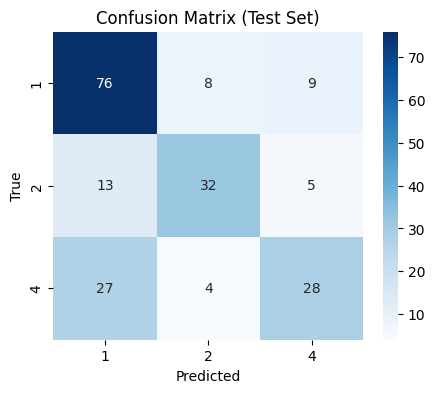

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the balanced dataset
df = pd.read_csv('/content/merged_file.csv')

# Optionally drop label 3 if it's still included
df = df[df['Label'] != 3]

# Separate features and label
X = df.drop(columns=['Label'])
y = df['Label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# Train on training data
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation report
print("Classification Report on Test Set:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(clf, '/content/random_forest_hrv.pkl')
print("Model saved!")


✅ Model saved!


In [ ]:
import pandas as pd
import joblib

# Load trained model
#clf = joblib.load('/content/random_forest_hrv.pkl')

# Load left-out subject features
test_df = pd.read_csv('/content/hrv_features_labeled_S16.csv')# <- change S11 to your left-out subject
test_df=test_df[test_df['Label'] != 3]

# Separate features and true labels
X_test = test_df.drop(columns=['Label'])
y_true = test_df['Label']

# Predict
y_pred = clf.predict(X_test)

# Create a DataFrame with true labels and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save to CSV file
result_df.to_csv('/content/predictions_results.csv', index=False)

# Optional: Classification report
from sklearn.metrics import classification_report
print("\n", classification_report(y_true, y_pred))



               precision    recall  f1-score   support

           1       0.77      0.44      0.56        39
           2       0.78      1.00      0.88        21
           4       0.37      0.54      0.44        24

    accuracy                           0.61        84
   macro avg       0.64      0.66      0.62        84
weighted avg       0.66      0.61      0.60        84



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load full dataset
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/merged_file.csv')

# Drop label 3 if it's still present
#df = df[df['Label'] != 3]

# Convert to binary stress label
df['BinaryLabel'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and target
X = df.drop(columns=['BinaryLabel'])  # make sure SubjectID is excluded
y = df['BinaryLabel']

# Train Random Forest on full data
clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
clf.fit(X, y)

# Save model
joblib.dump(clf, 'stress_rf_model.pkl')
print("Model saved as 'stress_rf_model.pkl'")


Model saved as 'stress_rf_model.pkl'


In [ ]:
print(df['BinaryLabel'].value_counts())


BinaryLabel
0    896
1    251
Name: count, dtype: int64


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# Load trained model
clf = joblib.load('/content/stress_rf_model.pkl')

# Load left-out subject features
test_df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S15.csv')  # Change 'S16' to your left-out subject ID

# Convert to binary: 1 = stress, 0 = no stress
test_df['BinaryLabel'] = test_df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and true labels
X_test = test_df.drop(columns=['BinaryLabel'])  # Only drop 'BinaryLabel', but keep 'Label'
y_true = test_df['BinaryLabel']

# Predict using the trained model
y_pred = clf.predict(X_test)

# Create a DataFrame with true labels and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save the results to a CSV file
result_df.to_csv('/content/predictions_results.csv', index=False)

# Optional: Print the classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        74
           1       1.00      0.95      0.98        22

    accuracy                           0.99        96
   macro avg       0.99      0.98      0.99        96
weighted avg       0.99      0.99      0.99        96



In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/merged_file.csv')


# Create binary labels
df['BinaryLabel'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and labels
X = df.drop(columns=['BinaryLabel', 'Label'])  # Ensure SubjectID and Label are not included
y = df['BinaryLabel']

# Create a pipeline with scaling + SVM (RBF kernel by default)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=42))
])

# Train the model
svm_pipeline.fit(X, y)

# Save the trained model
joblib.dump(svm_pipeline, 'stress_svm_model.pkl')
print("SVM model saved as 'stress_svm_model.pkl'")


SVM model saved as 'stress_svm_model.pkl'


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# Load the trained SVM model (which includes scaling in the pipeline)
svm_model = joblib.load('/content/stress_svm_model.pkl')

# Load the left-out subject's features
test_df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S17.csv')  # Update subject ID as needed

# Convert to binary labels: 1 = stress, 0 = no stress
test_df['BinaryLabel'] = test_df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and target
X_test = test_df.drop(columns=['BinaryLabel', 'Label'])  # Keep only actual feature columns
y_true = test_df['BinaryLabel']

# Predict using the trained SVM model
y_pred = svm_model.predict(X_test)

# Create a DataFrame with true and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save predictions to a CSV
result_df.to_csv('/content/predictions_svm_results.csv', index=False)

# Print the classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        73
           1       0.80      1.00      0.89        24

    accuracy                           0.94        97
   macro avg       0.90      0.96      0.92        97
weighted avg       0.95      0.94      0.94        97



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load full dataset
df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/merged_file.csv')

# Drop label 3 if it's still present
#df = df[df['Label'] != 3]

# Convert to binary stress label
df['BinaryLabel'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and target
X = df.drop(columns=['BinaryLabel'])  # make sure SubjectID is excluded
y = df['BinaryLabel']

# Train Random Forest on full data
clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
clf.fit(X, y)

# Check feature importance
importances = clf.feature_importances_

# Create a DataFrame to display feature importances
feature_names = X.columns  # or list of feature names if not a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)




Feature Importance:
         Feature  Importance
19         Label    0.301145
15     HRV_MinNN    0.150778
11   HRV_Prc20NN    0.130174
0     HRV_MeanNN    0.095848
6   HRV_MedianNN    0.057490
12   HRV_Prc80NN    0.045890
16     HRV_MaxNN    0.035034
10   HRV_SDRMSSD    0.019714
14     HRV_pNN20    0.016366
4       HRV_CVNN    0.015966
9      HRV_IQRNN    0.015501
8      HRV_MCVNN    0.015094
3       HRV_SDSD    0.014301
2      HRV_RMSSD    0.013827
13     HRV_pNN50    0.013730
5       HRV_CVSD    0.013187
1       HRV_SDNN    0.012815
7      HRV_MadNN    0.012726
17       HRV_HTI    0.011413
18      HRV_TINN    0.009000


In [ ]:
# Define features to drop based on their importance (e.g., those with importance < 0.01)
features_to_drop = ['HRV_HTI', 'HRV_TINN']

# Drop these features from the dataset
X_filtered = X.drop(columns=features_to_drop)

# Re-train the model with the reduced feature set
clf_filtered = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
clf_filtered.fit(X_filtered, y)

# Check feature importance again
importances_filtered = clf_filtered.feature_importances_

# Create a DataFrame to display feature importances
importance_df_filtered = pd.DataFrame({'Feature': X_filtered.columns, 'Importance': importances_filtered})
importance_df_filtered = importance_df_filtered.sort_values(by='Importance', ascending=False)

print("Filtered Feature Importance:")
print(importance_df_filtered)

# Save the updated model
joblib.dump(clf_filtered, 'stress_rf_model_filtered.pkl')
print("Filtered model saved as 'stress_rf_model_filtered.pkl'")


Filtered Feature Importance:
         Feature  Importance
17         Label    0.319990
15     HRV_MinNN    0.143417
0     HRV_MeanNN    0.108162
11   HRV_Prc20NN    0.096158
6   HRV_MedianNN    0.077586
12   HRV_Prc80NN    0.048688
16     HRV_MaxNN    0.032546
14     HRV_pNN20    0.020852
10   HRV_SDRMSSD    0.019107
8      HRV_MCVNN    0.019060
13     HRV_pNN50    0.015325
2      HRV_RMSSD    0.015035
9      HRV_IQRNN    0.014882
3       HRV_SDSD    0.014549
5       HRV_CVSD    0.014419
1       HRV_SDNN    0.013765
7      HRV_MadNN    0.013620
4       HRV_CVNN    0.012840
Filtered model saved as 'stress_rf_model_filtered.pkl'


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# Load trained model
clf = joblib.load('/content/stress_rf_model_filtered.pkl')

# Load left-out subject features
test_df = pd.read_csv('/content/drive/MyDrive/WESAD_pkl/ECG/hrv_features_labeled_S17.csv')  # Change 'S15' to your left-out subject ID

# Convert to binary: 1 = stress, 0 = no stress
test_df['BinaryLabel'] = test_df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and true labels
X_test = test_df.drop(columns=['BinaryLabel'])  # Only drop 'BinaryLabel', but keep 'Label'
y_true = test_df['BinaryLabel']

# Drop unimportant features based on feature importance
features_to_drop = ['HRV_HTI', 'HRV_TINN']  # Features with low importance from the earlier analysis
X_test_filtered = X_test.drop(columns=features_to_drop)

# Predict using the trained model (on filtered features)
y_pred = clf.predict(X_test_filtered)

# Create a DataFrame with true labels and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save the results to a CSV file
result_df.to_csv('/content/predictions_results_filtered.csv', index=False)

# Optional: Print the classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        24

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

